In [1]:
import json
import gzip
import re
import itertools
import regex
import pandas as pd
import gzip
import numpy as np
import datetime
import scipy.stats as stats
import math
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from typing import Optional
pd.options.mode.chained_assignment = None 

In [2]:
# Plot settings
plt.rcParams['figure.dpi'] = 100
sns.set()  # Use default seaborn styling for all plots
sns.set_context('notebook')

# Preproccesing:

As we have a very large dataset containing reviews of all amazon's products in  differents subsets by type:

* Books	
* Electronics	
* Movies and TV	
* CDs and Vinyl	
* Clothing, Shoes and Jewelry	
* Home and Kitchen	
* Kindle Store	
* Sports and Outdoors	
* Cell Phones and Accessories	
* Health and Personal Care	
* Toys and Games	
* Video Games	
* Tools and Home Improvement		
* Beauty	
* Apps for Android	
* Office Products	
* Pet Supplies	
* Automotive	5-core 
* Grocery and Gourmet Food	
* Patio, Lawn and Garden	
* Baby	5-core 
* Digital Music	
* Musical Instruments	
* Amazon Instant Video

For this step, we chose to work with a small subsets to perform our preprocessing, and to have a first idea how efficient it was since we don't handle textual data. We will start by exploring the data, products reviewed and ratings, and try to extract meaningful information, and then we will handle the textual reviews, clean it as much as possible.



* Useful functions for reading data, provided by Amazon.

In [3]:
def parse(path):
    
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Step A : Loading the dataset
* Reading the dataset and displaying some important figures.

In [4]:
df = getDF('data/samples/reviews_Video_Games_5.json.gz')
df_copy = df.copy()
# Get some informations about columns
df['reviewText'] = df.reviewText.astype('str')
df['asin'] = df.asin.astype('str')

print(df.dtypes) # type of each attribute 
df = df.dropna()

#df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'],unit='s')
#f.rename(columns={'unixReviewTime':'ReviewTime'},inplace=True)
#df['ReviewTime']

reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
dtype: object


In [5]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1.0,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4.0,Good rally game,1372550400,"06 30, 2013"
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1.0,Wrong key,1403913600,"06 28, 2014"
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]","I got this version instead of the PS3 version,...",3.0,"awesome game, if it did not crash frequently !!",1315958400,"09 14, 2011"
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,DIRT 3,1308009600,"06 14, 2011"


In [6]:
df.describe()

,overall,unixReviewTime
count,228967.000000,2.289670e+05
mean,4.085156,1.276435e+09
std,1.201180,1.158266e+08
min,1.000000,9.398592e+08
25%,4.000000,1.211760e+09
50%,5.000000,1.316650e+09
75%,5.000000,1.368144e+09
max,5.000000,1.405987e+09


In [8]:
# Basic figures for this sample.
nb_articles = df['asin'].unique().shape[0]
nb_reviewers = df['reviewerName'].unique().shape[0]
nb_reviews = df.shape[0]

print("Number of reviews : %d " % nb_reviews)
print("Number of articles reviewed : %d " % nb_articles)
print("Number of  reviewers  : %d " % nb_reviewers)


Number of reviews : 228967 
Number of articles reviewed : 10672 
Number of  reviewers  : 22349 


### Part 2 : Textual description preprocessing

1.  We try to create a dictionnary of text normalization, wchich can be helpful to substitute incorrect words with correct one. We have two references : 


 * link1( http://www.hlt.utdallas.edu/~yangl/data/Text_Norm_Data_Release_Fei_Liu/)
 * link2( http://luululu.com/tweet/typo-corpus-r1.txt)


In [14]:
def load_lexical_normalization():
    """
    Function to load lexical normalization dictionaries found online: 
        http://www.hlt.utdallas.edu/~yangl/data/Text_Norm_Data_Release_Fei_Liu/
        http://luululu.com/tweet/typo-corpus-r1.txt
    These dictionaries help perform a spell check on reviews and convert their 
    words to normal english words
    Result: lex_orm : a dictionary, the keys are incorrect words and the values are correct words
    """
    lex_norm = {}
    
    dictionary1 = open('helpers/TextNormalization.txt', 'rb')
    for word in dictionary1:
        word = word.decode('utf8')
        word = word.split()
        lex_norm[word[1]] = word[3]
    dictionary1.close()
    dictionary2 = open('helpers/TypoCorpus.txt', 'rb')
    for word in dictionary2:
        word = word.decode('utf8')
        word = word.split()
        lex_norm[word[0]] = word[1]
    dictionary2.close()
    return lex_norm
lex_norm = load_lexical_normalization()

def spell_check(review):
    """
    Function that corrects words using the corpus loaded with load_lexical_normalization()
    Arguments: 
        review: a string that represents the raw review
        lexNorm: a dictionary
    Result: a string that represents the corrected review
    """
    review = review.split()
    for i in range(len(review)):
        if review[i] in lex_norm.keys():
            review[i] = lex_norm[review[i]]
    review = ' '.join(review)
    return review


def clean_char_repetitions(review):
    """
    Function that removes repeated letters in words
    """
    
    review=review.split()
    for i in range(len(review)):
        review[i]=''.join(''.join(s)[:2] for _, s in itertools.groupby(review[i])).replace('#', '')

    review=' '.join(review)
    return review

def spell_preprocessing(review):
    ''' 
    Apply the two previous functions
    '''
    review = spell_check(review)
    return clean_char_repetitions(review)




# Add word  adn char count
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['reviewText'].str.len() 

df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,word_count,char_count
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1.0,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012",118,779
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4.0,Good rally game,1372550400,"06 30, 2013",53,304
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1.0,Wrong key,1403913600,"06 28, 2014",53,282
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]","I got this version instead of the PS3 version,...",3.0,"awesome game, if it did not crash frequently !!",1315958400,"09 14, 2011",646,3489
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,DIRT 3,1308009600,"06 14, 2011",62,294


# Applying textual preprocessing


In [15]:

df['reviewText'] = df['reviewText'].map(spell_preprocessing)

#Transform reviews to lower case to avoid repetitions of the words.
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing ponctuation
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]','')






[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aminetou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:

# Remove stopwords: that, is, are ..
nltk.download('stopwords')
stop = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aminetou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
print("List of stopwords filtred: \n ")
print(stop)

List of stopwords filtred: 
 
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 

In [22]:
#redo the word count 

df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['reviewText'].str.len() 

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,word_count,char_count
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",installing game struggle games windows live bu...,1.0,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012",63,529
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",like rally cars get game funit oriented 34euro...,4.0,Good rally game,1372550400,"06 30, 2013",28,184
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received book instead game2nd shi...,1.0,Wrong key,1403913600,"06 28, 2014",30,194
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]",got version instead ps3 version turned mistake...,3.0,"awesome game, if it did not crash frequently !!",1315958400,"09 14, 2011",342,2297
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",dirt 2 xbox 360 okay game started playing game...,4.0,DIRT 3,1308009600,"06 14, 2011",29,170


* We can se that we let go of many unusefull words, and with the remaining one we'll try to conduct the final analysis

# Next step of textual analysis

* For the next milestone, we're going to go deeper into natural language processing, and try to extract information from the text review or the summary (or both) and identify if there's a causality between high helpfulness and a good comment (review)

# Analysis Step : 
###  A/ Visualisation of data

Let's try and visualize distribution of ratings, We will handle:
1. Global ratings 
2. Mean rating per item
3. Mean rating per reviewer

##############################

1. Global ratings 


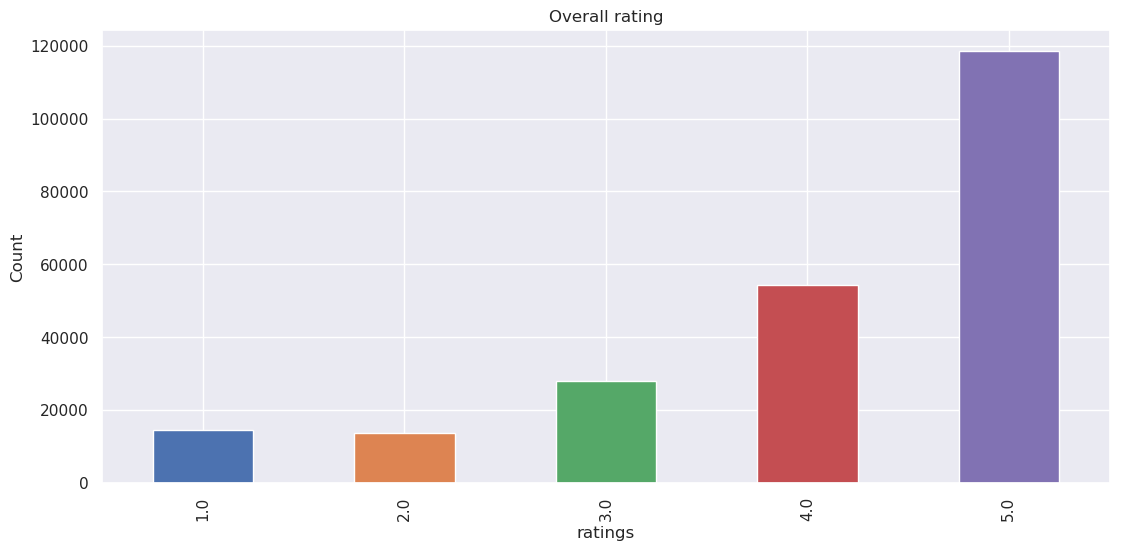

In [100]:
# Plot bins of ratings

summary = df.groupby('overall')['summary'].agg("count")
summary.plot(kind='bar')
plt.title('Overall rating')
plt.xlabel('ratings')
plt.ylabel('Count')
plt.rcParams["figure.figsize"] = [13,6]


We can see that a majority of rating scores are 5. 

In [24]:
gby_product = df.groupby('asin',as_index=False)['overall'].mean()


def get_mean_rating(asin):
    return gby_product[asin]

#df['meanRating'] = df['asin'].map(get_mean_rating)



In [102]:
# Plot the average rating per item


* Visualize reviewers' behavior towards the items

In [29]:
gby_reviewers = df.groupby('reviewerID',as_index=False)['overall'].mean()
gby_reviewers = pd.DataFrame(gby_reviewers)
gby_reviewers.head(5)

,reviewerID,overall
0,A00263941WP7WCIL7AKWL,4.333333
1,A005481137I9SCAWEF7ON,4.370370
2,A01588502N52TNG1BP7WG,4.666667
3,A01803182IUSFNIFF5984,3.800000
4,A023090719X7MTBCLM19B,5.000000


Text(0, 0.5, 'Count')

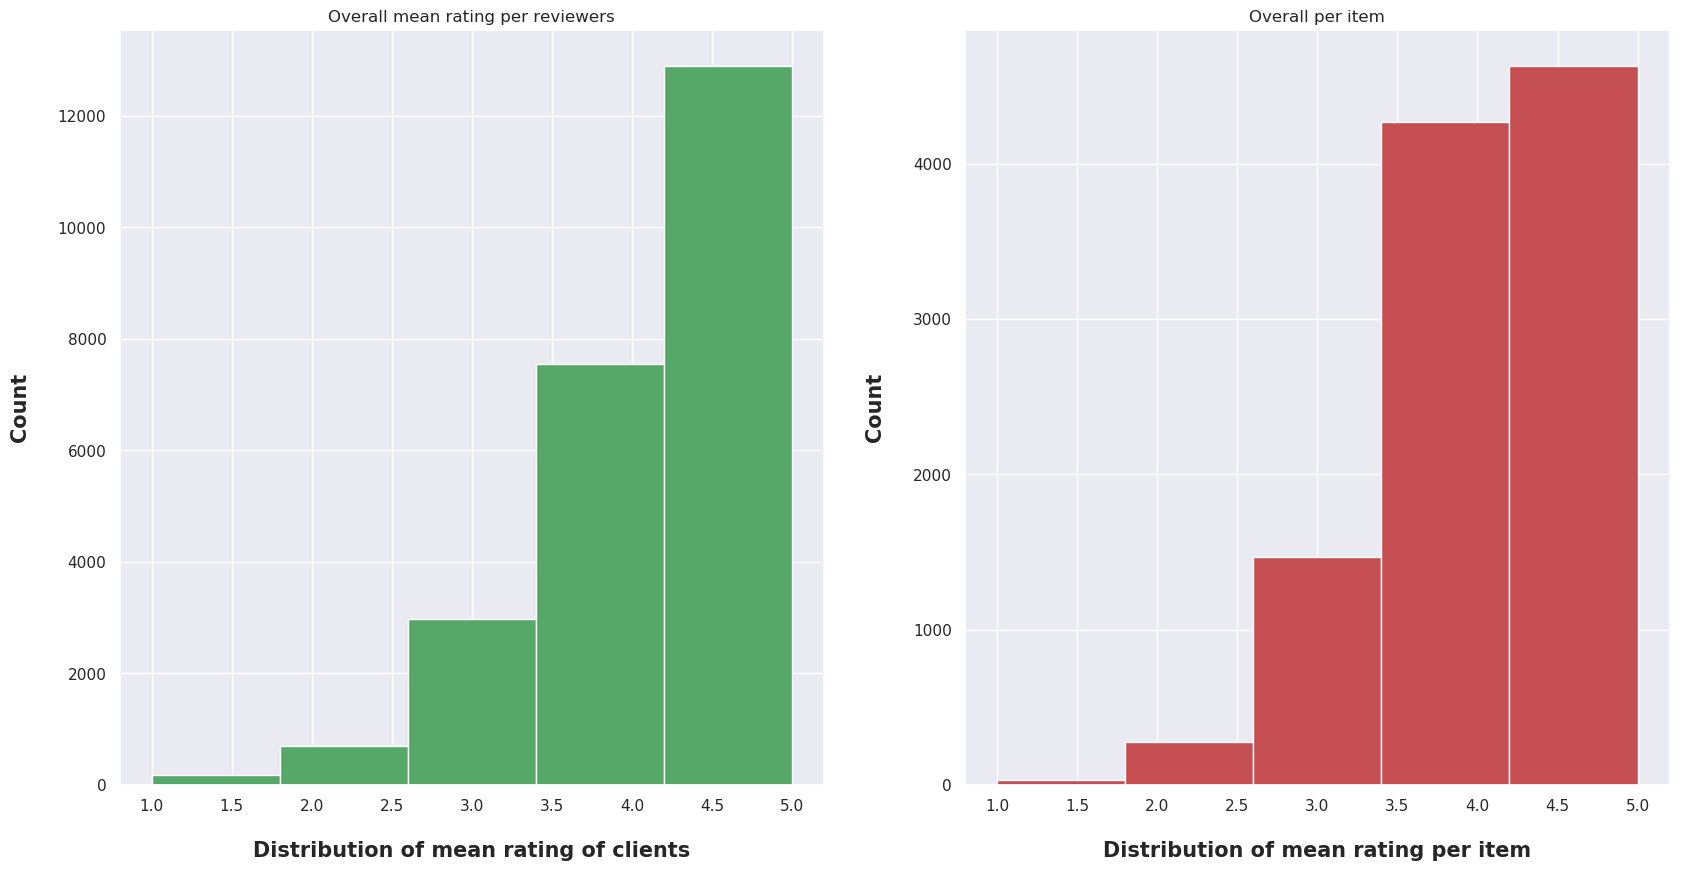

In [30]:
fig, axes = plt.subplots(1, 2,figsize=(20,10))

axes[0].hist(gby_reviewers['overall'], bins=5, facecolor='g')
axes[0].set_title('Overall mean rating per reviewers')
axes[0].set_xlabel('Distribution of mean rating of clients',labelpad=20, weight='bold', size=15)
axes[0].set_ylabel('Count',labelpad=20, weight='bold', size=15)

axes[1].hist(gby_product['overall'], bins=5, facecolor='r')
axes[1].set_title('Overall per item')
axes[1].set_xlabel('Distribution of mean rating per item',labelpad=20, weight='bold', size=15)
axes[1].set_ylabel('Count',labelpad=20, weight='bold', size=15)





In [31]:
mean_rating_items = gby_product['overall'].mean()
mean_rating_reviewers = gby_reviewers['overall'].mean()
mean_rating = df['overall'].mean()

print("Mean rating : %s " %mean_rating)
print("Mean rating per item : %s " %mean_rating_items)
print("Mean rating per reviewer : %s " %mean_rating_reviewers)

Mean rating : 4.085156376246359 
Mean rating per item : 3.988054864529413 
Mean rating per reviewer : 4.10252783527898 


### B/  try to analyze reviewers behavior

We're going to look into the number of reviews given for reviewers and see if there's any relationship between how often they give reviews and the rating they give.

In [32]:
def get_nb_reviews(reviewerID):
    return df[df.reviewerID == reviewerID].shape[0]

#gby_reviewers['nbreviews'] = gby_reviewers['reviewerID'].map(get_nb_reviews)
df['count'] = 1
gby_reviewers['count'] = df.groupby('reviewerID',as_index=False).agg({'count': sum})['count']

gby_reviewers = gby_reviewers.sort_values(by=['overall'],ascending = False)



Text(0.5, 1.0, 'Mean ratings vs number of reviews (per person)')

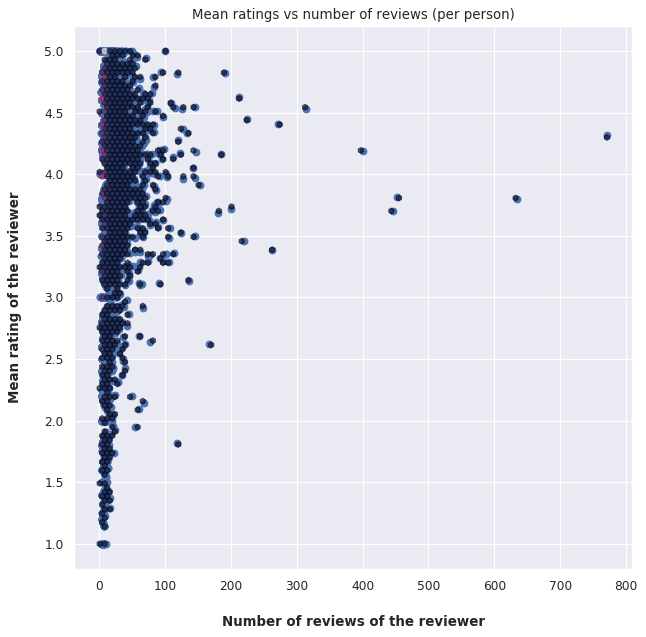

In [34]:
plt.figure(figsize=(9,9), dpi=80)
plt.scatter(gby_reviewers['count'], gby_reviewers.overall)
plt.hexbin(gby_reviewers['count'], gby_reviewers.overall, alpha=.6, mincnt=1)
plt.xlabel('Number of reviews of the reviewer',labelpad=20, weight='bold', size=12)
plt.ylabel('Mean rating of the reviewer',labelpad=20, weight='bold', size=12)
plt.title('Mean ratings vs number of reviews (per person)')


We notice that there is no clear relationship between number of reviews given and the average rating, and yet, we can still see that people who give a lot of reviews tend to rate items correctly, meanwhile people who doesn't often review items (less than 100 reviews) are the majority and hence, they are the decisive part.


### C/  Analysis of helpfulness of reviews


In [ ]:
def compute_ratio_help(h):
    if h[1] != 0:
        return 100*h[0] / h[1]
    else:
        return np.nan
    

df['helpful_ratio'] = df['helpful'].map(compute_ratio_help)
df_help = df[['helpful_ratio']].dropna()


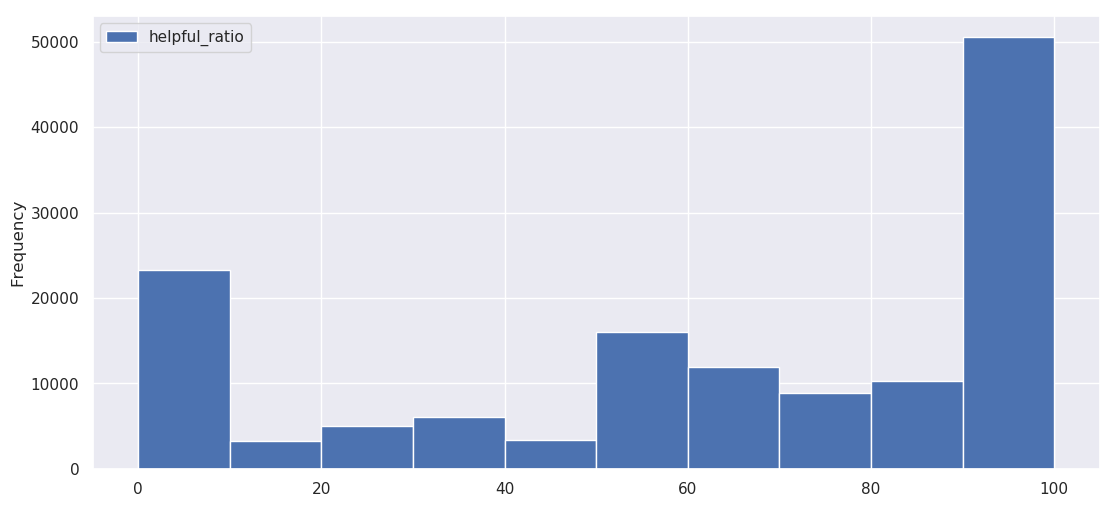

In [ ]:
df_help.head()

# Plot distributions of helpfulness
df_help.plot.hist(bins=10)


Helpfulness can be a useful metric for further analysis in the next step, since a majority of reviews can be considered as helpful. We can also extend the analysis to relationship between helpfulness of the review and the textual comment.

### D/ Effect of first reviews on other reviews.

* We work again with groupedbyItems
* We're going to collect the rating of the first reviews and compare it to the average rating of the item.

### This is one of the main questions we tried to answer, and we will continue to do so when we use the whole dataset, or at least try to find the category of items where this can be considered true.

In [ ]:
def get_first_rating(asin):
    
    dfi = df[df.asin == asin].sort_values(by='unixReviewTime').take(1)
    return dfi['asin'].iloc[0]

gby_product['first_rating'] = gby_product['asin'].map(get_first_rating)
gby_product



# Conclusion of this phase of descriptive analysis

1. We had some issues working with the whole dataset, so we chose to work firstly with a sample as a way to explore the data, and then we realised that many of questions we tried to work on are pretty hard to handle since we do not have enough to conclude. Yet, we still can work in depth concerning the influence of first reviews on the following ones.

2. We needed more knowledge about NLP to work with textual data since it represesents more than 70% of the data, we believe that it can be useful in next step

3. As for customer's behavior, we couldn' do much on a subset but if we ask for metadata (From the responsibles) we can work on it easily.

4. until Next step, we will choose two axis of analysis and drop the others because it became hard to focus on one or two ideas, we will do that in very soon to start looking towards the real analysis.